# New York City CitiBikes Analysis 
## Nasibeh Mohammadi

### The NewyYork Citibike dataset has more than 5 million records

### I used BigQuery Client, SQL and Python to analyse the dataset

### Importing necessary packages

In [2]:
import os 
from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import folium
from folium import plugins
import pandas as pd
import numpy as np
import plotly.express as px
import geocoder
from branca.element import Figure
from folium.plugins import HeatMapWithTime
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

<ipython-input-2-8de7387da909>:16: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-2-8de7387da909>:17: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


### For accessing to the dataset on BigQuery, we need a JSON key.

In [3]:
## Connceting to BigQuery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'avian-cogency-250008-69042ea26234.json'
bigquery_client = bigquery.Client()

## Let's have a look at the first 5 rows 

In [4]:
query= """
SELECT
    *
FROM
  `bigquery-public-data.new_york.citibike_trips`
LIMIT 5
    """
Query_Results = bigquery_client.query(query)
    
df = Query_Results.to_dataframe()
df

tripduration                 starttime                  stoptime  \
0           720 2014-08-04 11:28:18+00:00 2014-08-04 11:40:18+00:00   
1            88 2013-08-23 13:33:36+00:00 2013-08-23 13:35:04+00:00   
2            62 2015-11-06 10:20:39+00:00 2015-11-06 10:21:41+00:00   
3           285 2014-08-30 16:35:02+00:00 2014-08-30 16:39:47+00:00   
4          2160 2013-12-03 15:25:07+00:00 2013-12-03 16:01:07+00:00   

   start_station_id start_station_name  start_station_latitude  \
0               520    W 52 St & 5 Ave               40.759923   
1               520    W 52 St & 5 Ave               40.759923   
2               520    W 52 St & 5 Ave               40.759923   
3               520    W 52 St & 5 Ave               40.759923   
4               520    W 52 St & 5 Ave               40.759923   

   start_station_longitude  end_station_id end_station_name  \
0               -73.976485             520  W 52 St & 5 Ave   
1               -73.976485             520  W 52 St & 5 Ave   
2               -73.976485             520  W 52 St & 5 Ave   
3               -73.976485             520  W 52 St & 5 Ave   
4               -73.976485             520  W 52 St & 5 Ave   

   end_station_latitude  end_station_longitude  bikeid    usertype  \
0             40.759923             -73.976485   21500  Subscriber   
1             40.759923             -73.976485   19259  Subscriber   
2             40.759923             -73.976485   19102    Customer   
3             40.759923             -73.976485   17678    Customer   
4             40.759923             -73.976485   17595  Subscriber   

   birth_year   gender  
0      1954.0     male  
1      1985.0   female  
2         NaN  unknown  
3         NaN  unknown  
4      1979.0     male

# Insights about Trends & Patterns in NYC Citibike Project

## 1- Top 10 popular stations for starting a trip

In [5]:
query1 = """
SELECT
  start_station_name,
  start_station_latitude,
  start_station_longitude,
  COUNT(*) AS num_trips
FROM
  `bigquery-public-data.new_york.citibike_trips`
GROUP BY
  1,
  2,
  3
ORDER BY
  num_trips DESC
LIMIT 10
    """
Query_Results = bigquery_client.query(query1)
    
df1 = Query_Results.to_dataframe()


In [6]:
# Top 10 popular station for starting a trip on map

lats = df1['start_station_latitude']
longs = df1['start_station_longitude']
names = df1['start_station_name']
size = df1['num_trips']
places = [[x[0],x[1]] for x in zip(lats,longs)]

map = folium.Map(places[0], tiles='OpenStreetMap', zoom_start=12)
map.get_root().html.add_child(folium.Element('<h3 align="center" style="font-size:16px"><b>Popular stations for starting a trip</b></h3>'))
for i, loc in enumerate(places[1:]):
    folium.Marker(loc, icon=folium.Icon(), popup=f"Station: {names[i]}\nUsage:\n{size[i]}").add_to(map)
map.save('Top10.html')
map

#### We can use geocoder to extract census tract information from Latitude & Longitude.

In [7]:
# More info about the most popular station using geocoder

## Creating attributes for print function
name = df1.loc[df1.index[0], 'start_station_name']
s_latitude=df1.loc[df1.index[0], 'start_station_latitude']
s_longitude=df1.loc[df1.index[0], 'start_station_longitude']

print("The most popular station as both start station and end station is {0} at following location:".format(name))
print("The latitude of {0} and longitude of {1}".format(s_latitude,s_longitude))

g = geocoder.osm([s_latitude, s_longitude], method='reverse')
#print(g.json)
print('Neighborhood is', g.neighborhood)
print('Suburb is',g.suburb)
print('Type is',g.type)
print('Status is',g.status)

The most popular station as both start station and end station is E 17 St & Broadway at following location:
The latitude of 40.73704984 and longitude of -73.99009296
Neighborhood is Manhattan Community Board 5
Suburb is Manhattan
Type is bicycle_rental
Status is OK


## 2- the Longest Distance, the Shortest Time (Top 10)

Calculating the distance between start and end station based on the Latitude & Longitude and showing the fastest trip of corresponding route.

In [8]:
query2 = """
SELECT
  start_station_name,
  end_station_name,
  COUNT(*) trips,
  ROUND(AVG(ACOS( SIN(start_station_latitude*ACOS(-1)/180)*SIN(end_station_latitude*ACOS(-1)/180) + COS(start_station_latitude*ACOS(-1)/180)*COS(end_station_latitude*ACOS(-1)/180) * COS(end_station_longitude*ACOS(-1)/180-start_station_longitude*ACOS(-1)/180) ) * 6371000)) AS Distance,
  MIN(tripduration) AS Fastest_Trip,
FROM
  `bigquery-public-data.new_york.citibike_trips`
WHERE
  start_station_name != end_station_name
  AND start_station_latitude != 0
  AND end_station_latitude != 0
GROUP BY
  start_station_name,
  end_station_name
HAVING
  trips > 100
ORDER BY
  Distance DESC,
  Fastest_Trip 
    """
Query_Results= bigquery_client.query(query2)
    
df2 = Query_Results.to_dataframe()

df2.head(10)

start_station_name            end_station_name  trips  Distance  \
0          Broadway & Battery Pl          W 84 St & Broadway    102    9640.0   
1         Riverside Dr & W 82 St       Broadway & Battery Pl    123    9578.0   
2          Broadway & Battery Pl      Riverside Dr & W 82 St    133    9578.0   
3          Little West St & 1 Pl      Riverside Dr & W 82 St    231    9545.0   
4         Riverside Dr & W 82 St       Little West St & 1 Pl    208    9545.0   
5  Cumberland St & Lafayette Ave            11 Ave & W 59 St    181    9460.0   
6         Riverside Dr & W 82 St  South End Ave & Liberty St    120    8904.0   
7     South End Ave & Liberty St      Riverside Dr & W 82 St    162    8904.0   
8             Broadway & W 58 St     Fulton St & Rockwell Pl    103    8785.0   
9          Broadway & Battery Pl      Riverside Dr & W 72 St    116    8768.0   

   Fastest_Trip  
0          1775  
1          1602  
2          1817  
3          1607  
4          1653  
5           604  
6          1409  
7          1486  
8           447  
9          1571

## 3- Simulation of Busiest day trips on map

In [9]:
query3 = """
SELECT
    FORMAT_DATE('%F',starttime) AS date,
    COUNT(*) AS num_trips
FROM
  `bigquery-public-data.new_york.citibike_trips`
GROUP BY
  1
ORDER BY
  num_trips DESC
LIMIT 1
    """
Query_Results = bigquery_client.query(query3)
    
df3 = Query_Results.to_dataframe()
date = df3.loc[df3.index[0], 'date']
num_trips = df3.loc[df3.index[0], 'num_trips']

print("The busiest day was {0} with {1} number of trips".format(date,num_trips))


The busiest day was 2016-09-22 with 67810 number of trips


#### Extracting trips detail on the busiest day 2016-09-22

In [10]:
query4 = """
SELECT 
    *    
FROM 
  `bigquery-public-data.new_york.citibike_trips`

WHERE 
    FORMAT_DATE('%F',starttime) = '2016-09-22'

"""
Query_Results= bigquery_client.query(query4)
    
master_df = Query_Results.to_dataframe()


#### Extracting the list of trips per hours on the busiest day

In [11]:
master_df['hour'] = master_df['starttime'].dt.hour

# Create an empty list
df_hour_list = []

# Create a series with the different hours of the day
hours = pd.Series(sorted(master_df.hour.unique()))

# Create a list of points for each hour of the day
def create_list(hour):
                  df_hour_list.append(master_df.loc[master_df.hour == hour,
                                ['start_station_latitude',
                                 'start_station_longitude']].
                        groupby(['start_station_latitude', 
                                 'start_station_longitude']).sum().reset_index().values.tolist())
hours.apply(create_list)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
dtype: object

#### Show trip events of the busiest day to an interactive map, you can use the toolbar on the map to play the simulation.


In [12]:
map_time = folium.Map(location=[40.71958611647166, -74.0431174635887], 
                      tiles="CartoDB Positron", 
                      zoom_start=12)


HeatMapWithTime(df_hour_list, 
                auto_play=True, 
                max_opacity=0.5, 
                gradient = {0.2: '#FBD973', 
                            0.4: '#fa782f', 
                            0.75: '#F16578', 
                            1: '#782890'}).add_to(map_time)
map_time.save('map_time.html')
map_time

## 4- Visualising Slowest trip route on the map (top 5)

In [13]:
query5 = """
SELECT  
    *  
FROM 
    `bigquery-public-data.new_york.citibike_trips`
ORDER BY
    tripduration DESC
LIMIT 10 
        """
Query_Results= bigquery_client.query(query5)
    
df5 = Query_Results.to_dataframe()

In [14]:
## Creating list of location data of top 5 routes
list0=[]
list0.append([df5.loc[df5.index[0], 'start_station_latitude'],df5.loc[df5.index[0], 'start_station_longitude']])
list0.append([df5.loc[df5.index[0], 'end_station_latitude'],df5.loc[df5.index[0], 'end_station_longitude']])
list1=[]
list1.append([df5.loc[df5.index[1], 'start_station_latitude'],df5.loc[df5.index[1], 'start_station_longitude']])
list1.append([df5.loc[df5.index[1], 'end_station_latitude'],df5.loc[df5.index[1], 'end_station_longitude']])
list2=[]
list2.append([df5.loc[df5.index[2], 'start_station_latitude'],df5.loc[df5.index[2], 'start_station_longitude']])
list2.append([df5.loc[df5.index[2], 'end_station_latitude'],df5.loc[df5.index[2], 'end_station_longitude']])
list3=[]
list3.append([df5.loc[df5.index[3], 'start_station_latitude'],df5.loc[df5.index[3], 'start_station_longitude']])
list3.append([df5.loc[df5.index[3], 'end_station_latitude'],df5.loc[df5.index[3], 'end_station_longitude']])
list4=[]
list4.append([df5.loc[df5.index[4], 'start_station_latitude'],df5.loc[df5.index[4], 'start_station_longitude']])
list4.append([df5.loc[df5.index[4], 'end_station_latitude'],df5.loc[df5.index[4], 'end_station_longitude']])

In [15]:
from branca.element import Figure
import folium
from folium import plugins
fig5=Figure(height=550,width=750)
m5=folium.Map(location=[40.682232, -73.961458],tiles='cartodbpositron',zoom_start=11)
fig5.add_child(m5)

# Creating feature groups
f1=folium.FeatureGroup("Fulton St & Grand Ave")
f2=folium.FeatureGroup("Cleveland Pl & Spring St")
f3=folium.FeatureGroup("Vesey Pl & River Terrace")
f4=folium.FeatureGroup("Central Park S & 6 Ave")
f5=folium.FeatureGroup("Lexington Ave & E 24 St")



# Adding lines to the different feature groups
line_1=folium.vector_layers.PolyLine(list0,color='blue',weight=3).add_to(f1)
line_2=folium.vector_layers.PolyLine(list1,color='red',weight=3).add_to(f2)
line_3=folium.vector_layers.PolyLine(list2,color='green',weight=3).add_to(f3)
line_4=folium.vector_layers.PolyLine(list3,color='brown',weight=3).add_to(f4)
line_5=folium.vector_layers.PolyLine(list4,color='orange',weight=3).add_to(f5)

f1.add_to(m5)
f2.add_to(m5)
f3.add_to(m5)
f4.add_to(m5)
f5.add_to(m5)


folium.LayerControl().add_to(m5)
m5

### As we see on the map (above) there are some routes that have very slow trip but short distance!

## 5- the Average Trip per Month

In [16]:
query6 = """
SELECT
  EXTRACT(year FROM starttime) AS year, FORMAT_DATE('%m',starttime) AS month, AVG(tripduration)/60 AS avg_duration_in_minutes 
FROM
    `bigquery-public-data.new_york.citibike_trips`
GROUP BY 
    year, month
HAVING 
  year IS NOT NULL
ORDER BY
  year, month
  
            """
Query_Results= bigquery_client.query(query6)
    
df6 = Query_Results.to_dataframe()


In [17]:
def num_to_month(num):
    list_of_months = {'01': 'January', '02': 'February', '03': 'March',
                              '04': 'April', '05': 'May', '06': 'June', '07': 'July',
                              '08': 'August', '09': 'September', '10': 'October',
                              '11': 'November', '12': 'December'}

    return list_of_months[num]
df6['month_name'] = df6['month'].apply(num_to_month)
df6['date']=df6['year'].astype(str) + ' - ' + df6['month_name']
df6 = df6.drop(columns=['year','month','month_name'])

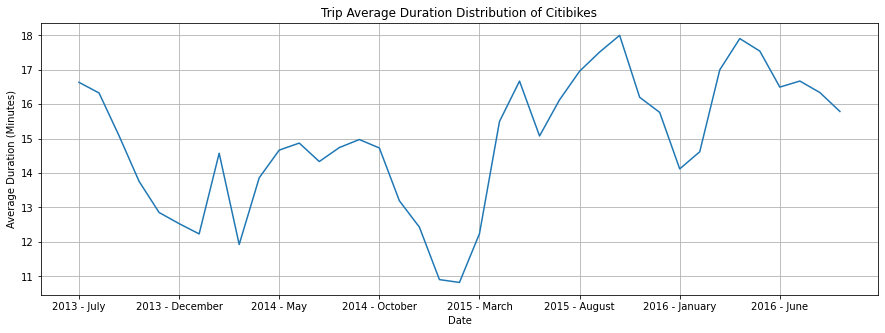

In [18]:
df6.plot.line( x='date', y="avg_duration_in_minutes", figsize=(15,5),legend=False, grid = True)
plt.xlabel('Date')
plt.ylabel('Average Duration (Minutes)')
plt.title('Trip Average Duration Distribution of Citibikes')
plt.show()

## 6- Bike Trips per Age per Gender

In [19]:
query7 = """

SELECT 
      (EXTRACT(year FROM starttime) - CAST(birth_year AS INT64)) AS age,
      COUNT(*) count, 
      COUNT(CASE WHEN gender = "male" THEN 1 END) AS males,
      COUNT(CASE WHEN gender = "female" THEN 1 END) AS females 
FROM 
      `bigquery-public-data.new_york.citibike_trips`
WHERE 
    birth_year IS NOT NULL
GROUP BY 
    age
ORDER BY 
    age 
"""
Query_Results= bigquery_client.query(query7)
    
df7 = Query_Results.to_dataframe()


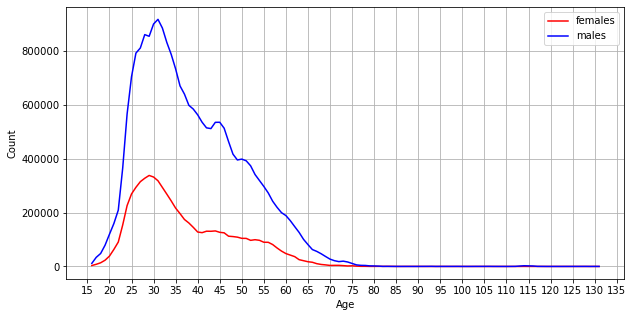

In [20]:
ax=df7.plot.line(x='age', y=['females','males'], figsize=(10,5),color=['red','blue'])
ax.grid(zorder=0)
plt.ylabel("Count")
plt.xlabel("Age")
plt.xticks(np.arange(15, 140, 5.0))
plt.show()

## 7- weekly usage

In [21]:
query8 = """
SELECT 
    FORMAT_DATE('%A',starttime) AS day,
    COUNT(*) AS count
FROM 
  `bigquery-public-data.new_york.citibike_trips`
GROUP BY 
    day
ORDER BY 
    count DESC

"""
Query_Results= bigquery_client.query(query8)
    
df8 = Query_Results.to_dataframe()

Text(0.5, 1.0, 'Weekly Usage\n')

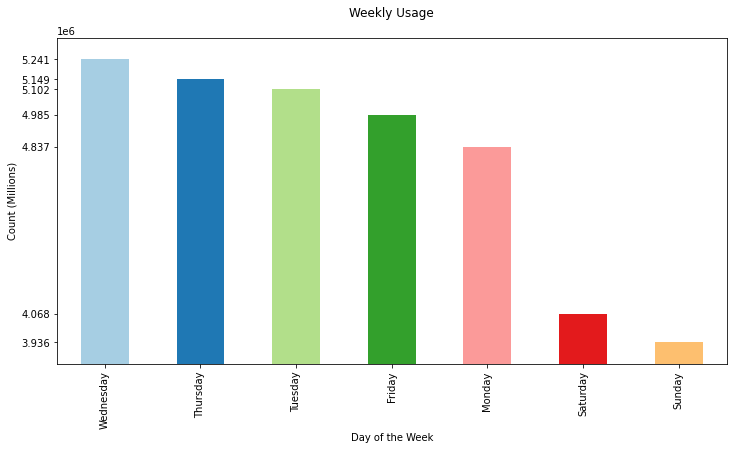

In [22]:
min=df8['count'].min()
max=df8['count'].max()
ax=df8.plot(x='day', y='count', kind='bar',color=plt.cm.Paired(np.arange(len(df8))),legend = False, figsize=(12,6),yticks =df8['count'],ylim =(min-  1e5,max+  1e5))

plt.ylabel("Count (Millions)")
plt.xlabel("Day of the Week")
plt.title("Weekly Usage\n")

## 8- Trips per User Type

In [23]:
query9 = """
SELECT  
  usertype,  
  COUNT(*) AS Trips,  
  AVG(tripduration) AS Avrage_Duration
FROM  
  `bigquery-public-data.new_york.citibike_trips`
GROUP BY 
    usertype
"""
Query_Results= bigquery_client.query(query9)
    
df9 = Query_Results.to_dataframe()
df9=df9.set_index('usertype')


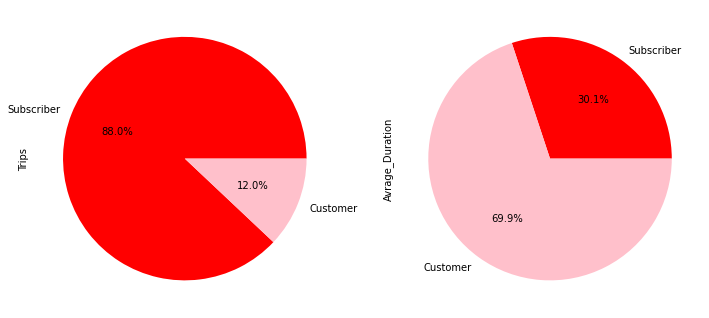

In [24]:
plot = df9.plot.pie(subplots=True,figsize=(12, 8),autopct='%1.1f%%', startangle=0, legend = False,colors = ['red', 'pink'] )


### As we see in the above diagram, Although Subscribers has the most number of trips, the Customers has the most trip duration.

## 9- Visualising the trips attributes from the busiest start station 'E 17 St & Broadway'

In [25]:
query_master = """
SELECT 
    *
FROM 
  `bigquery-public-data.new_york.citibike_trips`
WHERE
    start_station_name='E 17 St & Broadway'
"""
Query_Results= bigquery_client.query(query_master)
    
masterdf = Query_Results.to_dataframe()

In [26]:
## Extrating the time parts from dataframe 
masterdf['Month'] = masterdf['starttime'].dt.month
masterdf['Day'] = masterdf['starttime'].dt.day
masterdf['Year'] = masterdf['starttime'].dt.year
masterdf['Hour'] = masterdf['starttime'].dt.hour
masterdf['Season'] = masterdf['starttime'].dt.quarter
masterdf['Date'] = masterdf['starttime'].dt.strftime('%m/%Y')
masterdf = masterdf.sort_values(by=['starttime'], ascending = True)
masterdf['tripduration (hour)'] = masterdf['tripduration']/3600

#### We can calculate Speed based on Distance / Duration using lat & long columns

In [27]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


masterdf['Distance']= haversine(masterdf['start_station_latitude'],masterdf['start_station_longitude'],
                                masterdf['end_station_latitude'] ,masterdf['end_station_longitude'] )
masterdf['Speed'] =masterdf['Distance']/masterdf['tripduration (hour)'] 

In [28]:
masterdf['Age'] =masterdf['Year']-masterdf['birth_year'] ## Calculation user age at the time of commuting using birth year and start year

# Making the age group from age 
bins= [13,20,30,60,140]
labels = ['Teen','Youth','Adult','Old']
masterdf['AgeGroup'] = pd.cut(masterdf['Age'], bins=bins, labels=labels, right=False)

<AxesSubplot:xlabel='Year', ylabel='count'>

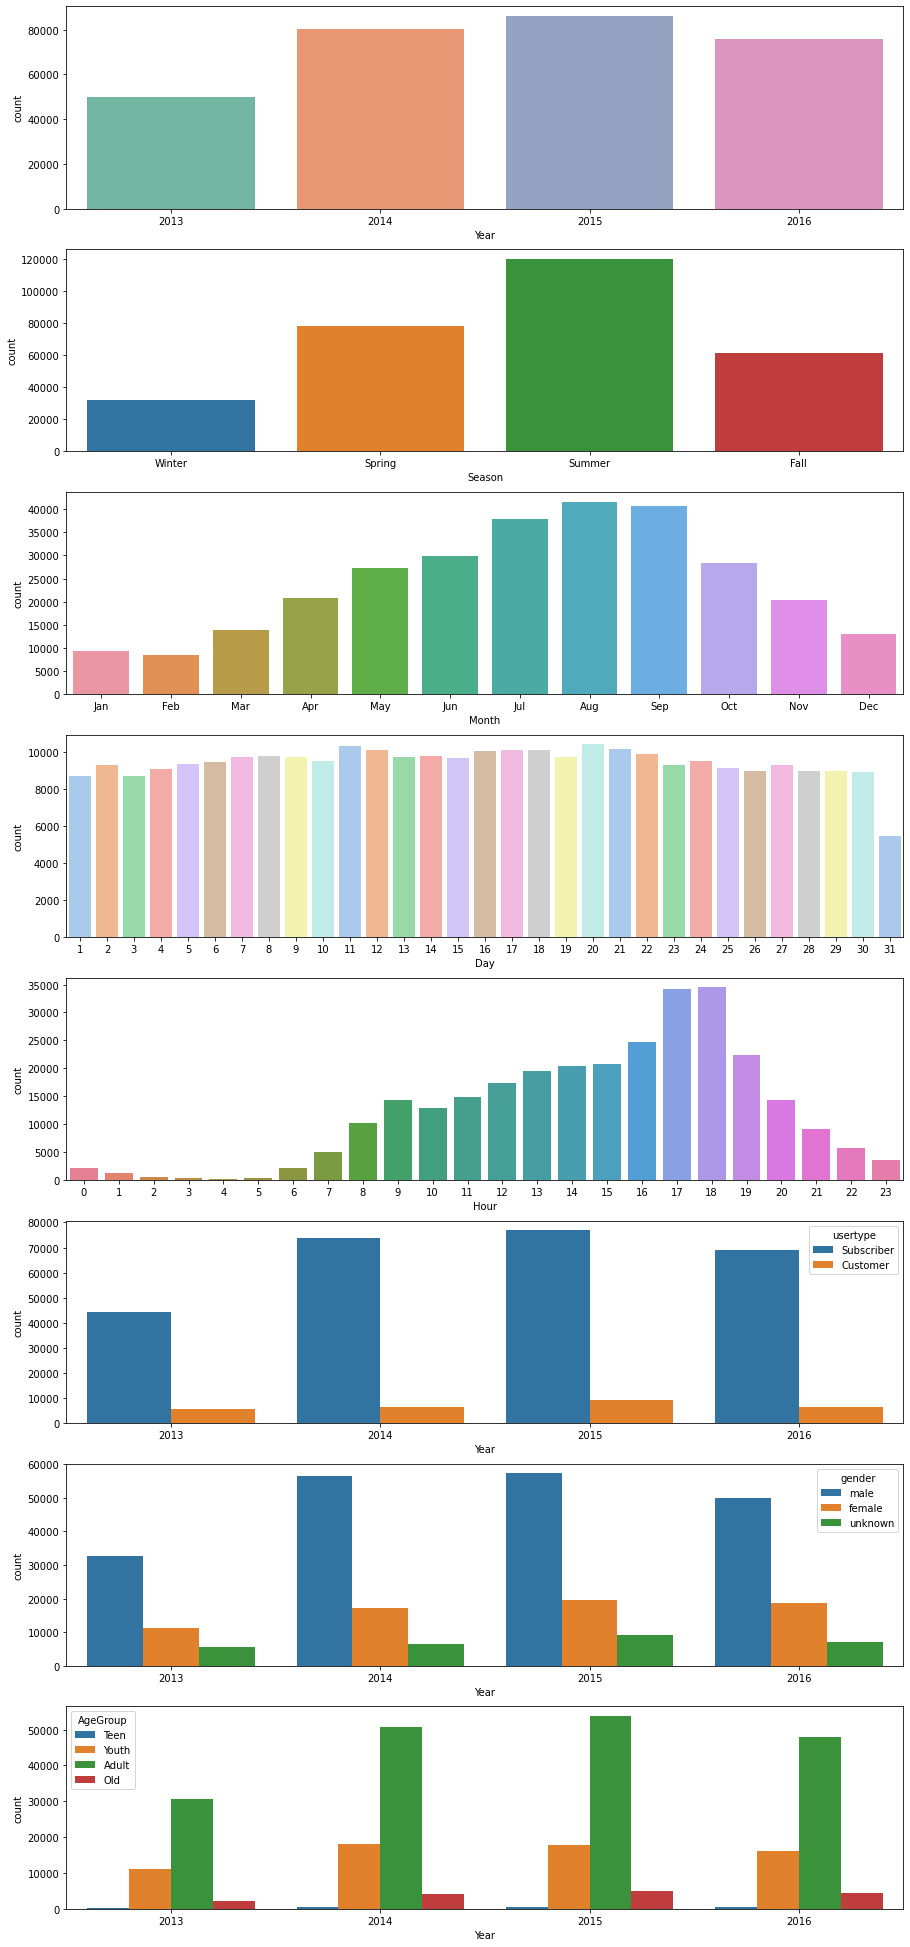

In [30]:
figure, ((ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)) = plt.subplots(nrows=8, ncols =1)
figure.set_size_inches(15,35)

sns.countplot(data=masterdf, x = 'Year', ax = ax1,palette='Set2')
sns.countplot(data=masterdf, x = 'Season', ax = ax2)
ax2.set(xticks=range(4), xticklabels=['Winter', 'Spring','Summer','Fall'])
sns.countplot(data=masterdf, x = 'Month', ax = ax3)
ax3.set(xticks=range(12), xticklabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
sns.countplot(data=masterdf, x = 'Day', ax = ax4,palette='pastel')
sns.countplot(data=masterdf, x = 'Hour', ax = ax5,palette='husl')
sns.countplot(data=masterdf, x = 'Year', hue = 'usertype', ax=ax6)
sns.countplot(data=masterdf, x = 'Year', hue = 'gender', ax=ax7)
sns.countplot(data=masterdf, x = 'Year', hue = 'AgeGroup', ax=ax8)

In [31]:
df_w=pd.DataFrame()
df_w['tripduration']=masterdf['tripduration']
df_w['starttime']=masterdf['starttime']
df_w.index = df_w['starttime']
weekdays = df_w[df_w.index.weekday < 5]
weekends = df_w[df_w.index.weekday > 4]
weekdays_countsPerHr = weekdays.groupby(weekdays.index.hour).size()
weekends_countsPerHr = weekends.groupby(weekends.index.hour).size()


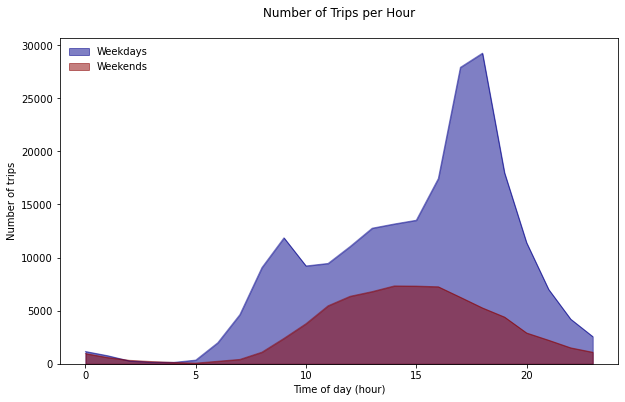

In [32]:
# Plot counts / hour on weekdays and weekends


weekdays_countsPerHr.plot(kind = 'area',x='session' ,stacked = False, figsize = (10, 6), color = 'darkblue',
                          linewidth =1, label='Weekdays')

weekends_countsPerHr.plot(kind = 'area', x='session',stacked = False, color = 'darkred',
                          linewidth = 1, label='Weekends')

plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.title('Number of Trips per Hour\n')
plt.xlabel('Time of day (hour)')
plt.ylabel('Number of trips')
plt.legend(loc='upper left', frameon = False)

In [35]:

fig1 = px.histogram(masterdf, x="AgeGroup", histfunc='count', facet_col='usertype', color="gender")
fig1.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig1.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig1.show()

## 10- the Trip Duration Distribution of Citibike trips

In [36]:
query10 = """
SELECT 
    CONCAT(bucket * 50, '-', (bucket * 50 - 1) + 50) AS duration_band, COUNT(tripduration) AS duration_count
FROM  
    (SELECT *, FLOOR(tripduration/(3600*50)) AS bucket FROM `bigquery-public-data.new_york.citibike_trips`) t1 
GROUP BY
    duration_band 
ORDER BY 
    duration_band
    """
Query_Results = bigquery_client.query(query10)
    
df10 = Query_Results.to_dataframe()

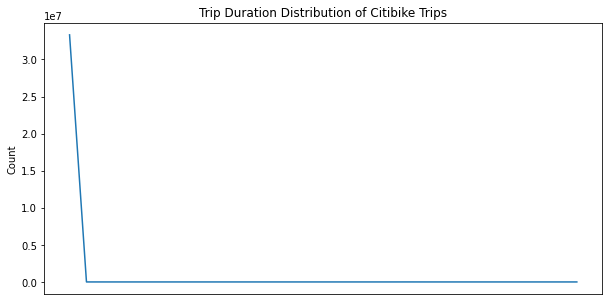

In [37]:
df10.plot.line(x="duration_band", y="duration_count", figsize=(10,5),legend=False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.xlabel('Duration Band (hours)')
plt.ylabel('Count')
plt.title('Trip Duration Distribution of Citibike Trips')
plt.show()

### We want to visualise the first part of the above diagram in more detail, so we remove the trips duration more than one day! which is more logical.

In [38]:
query11 = """
SELECT 
    tripduration/3600 AS duration_hour, COUNT(*) AS duration_count
FROM   
    `bigquery-public-data.new_york.citibike_trips`
GROUP BY 
    duration_hour
Having 
    duration_hour < 24
ORDER BY 
    duration_hour

    """
Query_Results = bigquery_client.query(query11)
    
df11= Query_Results.to_dataframe()


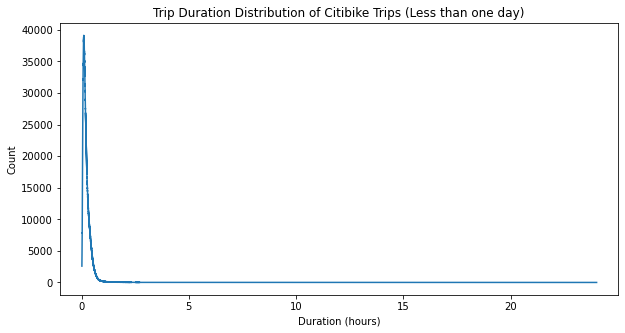

In [39]:
df11.plot.line(x="duration_hour", y="duration_count", figsize=(10,5),legend=False)
plt.xlabel('Duration (hours)')
plt.ylabel('Count')
plt.xlim(-1,df11.duration_hour.max()+1)
plt.title('Trip Duration Distribution of Citibike Trips (Less than one day)')
plt.show()

### As we seen most of the trips had less than 1 hours duration, so we visualise these trips

In [40]:
query12 = """
SELECT 
    ROUND(tripduration/60) AS duration_min,
    COUNT(*) AS duration_count
FROM   
    `bigquery-public-data.new_york.citibike_trips`
GROUP BY 
    duration_min
Having 
    duration_min < 60
ORDER BY 
    duration_min
    """
Query_Results = bigquery_client.query(query12)
    
df12 = Query_Results.to_dataframe()


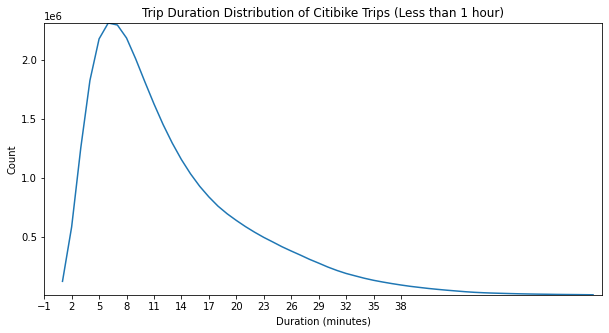

In [41]:
df12.plot.line(x="duration_min", y="duration_count", figsize=(10,5),legend=False)
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.xlim(-1,df12.duration_min.max()+1)
plt.ylim(df12.duration_count.min()-100,df12.duration_count.max()+100)
plt.xticks(np.arange(-1, 40, 3.0))

plt.title('Trip Duration Distribution of Citibike Trips (Less than 1 hour)')
plt.show()

### Most trips had duration between 6 to 9 minutes!

## 11- Number of Bikes

In [42]:
query13 = """
SELECT 
    EXTRACT(YEAR from starttime) AS year,  
    COUNT(DISTINCT(bikeid)) AS num_bikes
FROM 
    `bigquery-public-data.new_york.citibike_trips`
GROUP BY 
    year
ORDER BY 
    year
        """
Query_Results= bigquery_client.query(query13)
    
df13 = Query_Results.to_dataframe()


Text(0.5, 1.0, 'Bikes per Year')

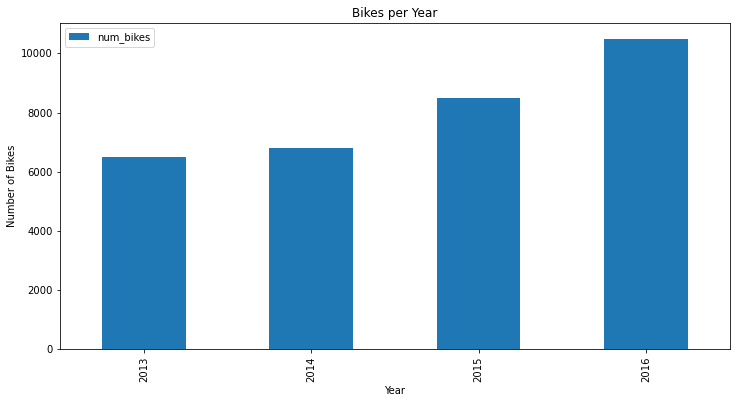

In [43]:
df13.plot.bar(x='year', y='num_bikes', figsize=(12,6), legend='False')
plt.ylabel("Number of Bikes")
plt.xlabel("Year")
plt.title("Bikes per Year")

## 12- the Gender Distribution of Citibike Users

In [44]:
query14 = """
SELECT
    gender,
    COUNT(*) AS num_gender,
    COUNT(*)/ SUM(COUNT(*)) OVER () AS Probability
FROM
  `bigquery-public-data.new_york.citibike_trips`
GROUP BY
    gender
    """
Query_Results= bigquery_client.query(query14)
    
df14 = Query_Results.to_dataframe()

Text(0, 0.5, 'Probability')

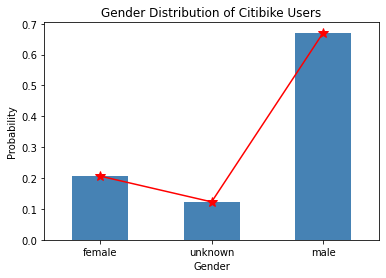

In [45]:
ax2=df14.plot(x='gender', y='Probability' , kind='bar', legend=False, color='steelblue')
ax2.set_xticklabels(df14.gender)
df14['Probability'].plot(kind='line', marker='*', color='red', ms=10)

plt.title("Gender Distribution of Citibike Users")
plt.xlabel("Gender")
plt.ylabel('Probability')


## 13- Bike Trips per Year per Gender

In [46]:
query15 = """
    SELECT  
        EXTRACT( year FROM starttime) AS year,
        COUNT(CASE WHEN gender= "female" THEN 1 END) AS female,
        ROUND(COUNT(CASE WHEN gender= "female" THEN 1 END)/COUNT(gender)*100, 2) AS female_percentage,
        COUNT(CASE WHEN gender = "male" THEN 1 END) AS male,
        ROUND(COUNT(CASE WHEN gender = "male" THEN 1 END)/COUNT(gender)*100, 2) AS male_percentage
    FROM 
  `bigquery-public-data.new_york.citibike_trips`
    GROUP BY 
        year
    HAVING 
        year IS NOT NULL
    ORDER BY
        year ASC
"""
Query_Results= bigquery_client.query(query15)
    
df15 = Query_Results.to_dataframe()


Text(0.5, 1.0, 'Bike Trips per Year per Gender')

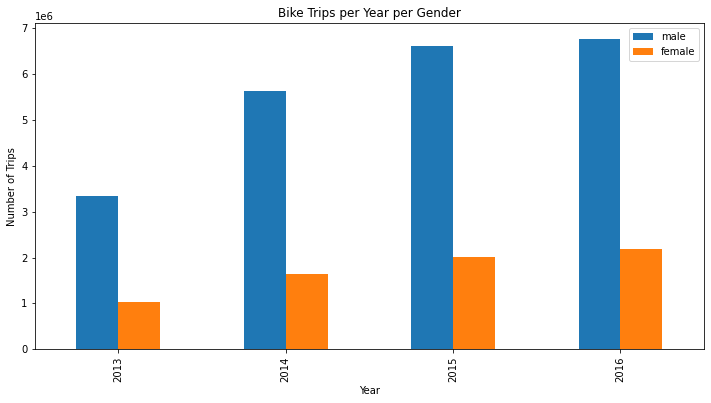

In [47]:
df15.plot(x='year', y=['male','female'], kind='bar', figsize=(12,6))
plt.ylabel("Number of Trips")
plt.xlabel("Year")
plt.title("Bike Trips per Year per Gender")

## 14- The most Popular Routes (by subscriber type and duration and number of trips)

In [48]:
query16 = """
SELECT
  usertype,
  CONCAT(start_station_name, " to ", end_station_name) AS route,
  COUNT(*) AS num_trips,
  ROUND(AVG(CAST(tripduration AS INT64) / 60),2) AS avg_duration_minutes
FROM
  `bigquery-public-data.new_york.citibike_trips`
GROUP BY
  start_station_name, end_station_name, usertype
ORDER BY
  num_trips DESC
LIMIT 10;
        """
Query_Results = bigquery_client.query(query16)
    
df16 = Query_Results.to_dataframe()

usertype = df16.loc[df16.index[0], 'usertype']
route=df16.loc[df16.index[0], 'route']
num_trips=df16.loc[df16.index[0], 'num_trips']
duration=df16.loc[df16.index[0], 'avg_duration_minutes']

print("The most popular route is {0} with {1} number of trips with the time duration of {2} minutes by user type {3}.".format(route,num_trips,duration,usertype))

The most popular route is Central Park S & 6 Ave to Central Park S & 6 Ave with 40009 number of trips with the time duration of 50.89 minutes by user type Customer.


## 15- the most Popular Citibike Routes for Women (top 10)

In [49]:
query17 = """
SELECT
  CONCAT(start_station_name, " to ", end_station_name) AS route,
  COUNT(*) AS num_trips
FROM
  `bigquery-public-data.new_york.citibike_trips`
WHERE
  gender = "female" 
GROUP BY
  start_station_name,
  end_station_name
ORDER BY
  num_trips DESC
LIMIT 10;
        """
Query_Results= bigquery_client.query(query17)
    
df17 = Query_Results.to_dataframe()

df17

route  num_trips
0                W 21 St & 6 Ave to W 22 St & 10 Ave       3110
1                 W 21 St & 6 Ave to 9 Ave & W 22 St       2627
2     West St & Chambers St to West St & Chambers St       2537
3         West Thames St to Vesey Pl & River Terrace       2443
4  DeKalb Ave & Vanderbilt Ave to DeKalb Ave & Hu...       2379
5          12 Ave & W 40 St to West St & Chambers St       2376
6  Cleveland Pl & Spring St to Lafayette St & E 8 St       2328
7         E 7 St & Avenue A to Lafayette St & E 8 St       2287
8      Henry St & Grand St to Norfolk St & Broome St       2253
9       Henry St & Grand St to Canal St & Rutgers St       2223

## 16- Male and Female Ride Time per Year

In [50]:
query18 = """
SELECT
  EXTRACT(year  FROM starttime) AS year,
  SUM(CASE WHEN gender='male' THEN tripduration END)/60*60 AS Male_ride_time_hours,
  SUM(CASE WHEN gender='female' THEN tripduration END)/60*60 AS Female_ride_time_hours
FROM
    `bigquery-public-data.new_york.citibike_trips`
GROUP BY
  year
HAVING 
  year is NOT NULL
ORDER BY
  year DESC
          """
Query_Results= bigquery_client.query(query18)
    
df18 = Query_Results.to_dataframe()
df18

year  Male_ride_time_hours  Female_ride_time_hours
0  2016          5.397053e+09            2.063674e+09
1  2015          5.142384e+09            1.878910e+09
2  2014          4.165423e+09            1.427969e+09
3  2013          2.518882e+09            9.255668e+08

## 17- User Type Ride Time per Year

In [51]:
query19 = """
SELECT
  EXTRACT(year FROM starttime) AS year,
  SUM(CASE WHEN usertype='Subscriber' THEN tripduration END)/60*60 AS Subscriber_ride_time_hours,
  SUM(CASE WHEN usertype='Customer' THEN tripduration END)/60*60 AS Customer_ride_time_hours
FROM
    `bigquery-public-data.new_york.citibike_trips`
GROUP BY
    year
HAVING 
    year is NOT NULL
ORDER BY
    year DESC
          """
Query_Results= bigquery_client.query(query19)
    
df19 = Query_Results.to_dataframe()
df19

year  Subscriber_ride_time_hours  Customer_ride_time_hours
0  2016                7.537664e+09              2.603368e+09
1  2015                7.030966e+09              2.589860e+09
2  2014                5.594687e+09              1.283843e+09
3  2013                3.444557e+09              1.026642e+09